In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import pydot

%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Pre-processing Data

In [2]:
arthroData = pd.read_csv('dataFiles/kneeAprHospFeat.csv')
arthroData.shape

C:\Users\rachelsim\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(112842, 68)

In [6]:
colsRemove = ['Length of Stay', #same as days
             'APR DRG Code', #all 540
             'APR DRG Description', #all c-sections
             'lonlat', #spatial 
             'geometry', #spatial
             'puma', #spatial
             'rural_versus_urban_R', #binary represented by rural_versus_urban_U
             'lat', #spatial
             'long', #spatial
             'Unnamed: 0', #extra index
             'Provider ID', #same as facility id
              'number_of_interns_and',
              'Total Costs', # related to charges
              'ratioChargesCosts',
              'chargesPerDay', 
              'ratioSumChargesPerFacPerYrToBedDays',
              'sumChargesPerFacIdPerYr',
              'totalFertile',
              'ratioFertilityTotalPopulation'
             ]


arthroData.drop(columns=colsRemove, inplace=True)
arthroData.shape

(112842, 49)

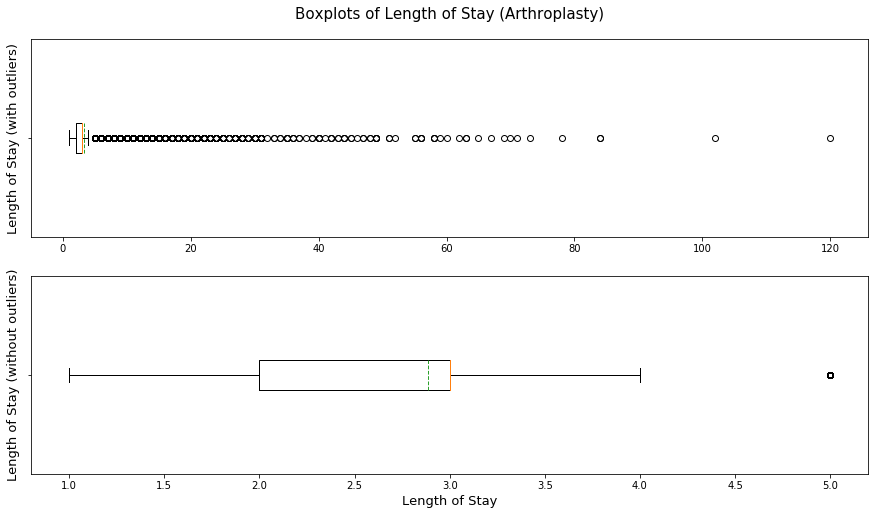

In [14]:
plt.figure(figsize=(15,8))

ax1 = plt.subplot(211)
ax1.boxplot(arthroData['days'], vert=False, meanline=True, showmeans=True)
ax1.set_ylabel('Length of Stay (with outliers)', fontsize=13)
ax1.set_title('Boxplots of Length of Stay (Arthroplasty)', fontsize=15, pad=20)
ax1.set_yticklabels([])

ax2 = plt.subplot(212)
ax2.boxplot(arthroData[arthroData['days'] <= 5]['days'], vert=False, meanline=True, showmeans=True)
ax2.set_ylabel('Length of Stay (without outliers)', fontsize=13)
ax2.set_xlabel('Length of Stay', fontsize=13)
ax2.set_yticklabels([])
plt.show()

In [18]:
len(arthroData[arthroData['days'] > 5])/len(arthroData)

0.07259708264653232

We only keep data with days of stay less than or equal to seven (one week), losing 7.26% of the data.

In [19]:
arthroData = arthroData[arthroData['days'] <= 5]

Drop all rows with NaNs.

In [20]:
arthroData.dropna(axis=0, inplace=True)
arthroData.reset_index(inplace=True, drop=True)
arthroData.shape

C:\Users\rachelsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(82116, 49)

In [21]:
82116/112842

0.7277077683841123

We are left with 72.8% of the data which is still plenty.

### Normalize Non-Discrete Features

In [22]:
cols_to_scale = ['fte_employees_on_payroll', 'number_of_beds',
                 'totalPopulation', 'totalInsured',
                 'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr',
                 'ratioDrgToFacility', 'numberOfPaymentTypes',
                 'numberUrgentAdmits', 'ratioInsuredTotalPopulation',
                 'days', 'avgNumberDays', 'Total Charges']

In [23]:
for cols in range(len(cols_to_scale)):
    arthroData[str('scale_'+cols_to_scale[cols])] = scale(arthroData[cols_to_scale[cols]])

C:\Users\rachelsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\rachelsim\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [24]:
arthroData['Facility Id'] = arthroData['Facility Id'].astype('int64')

C:\Users\rachelsim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [25]:
# get dummies for facility ids and health service area
fidDummies = pd.get_dummies(arthroData['Facility Id'], prefix='fid')
hsaDummies = pd.get_dummies(arthroData['Health Service Area'], prefix='hsa')
dummies = [fidDummies, hsaDummies]
dummiesDf = pd.concat(dummies, axis=1)

In [26]:
print(fidDummies.shape)
print(hsaDummies.shape)
print(dummiesDf.shape)

(82116, 93)
(82116, 8)
(82116, 101)


In [27]:
arthroData.drop(columns=['Facility Id', 'Health Service Area'], inplace=True)
arthroData = arthroData.merge(dummiesDf, left_index=True, right_index=True)
arthroData.shape

C:\Users\rachelsim\Anaconda3\lib\site-packages\pandas\core\frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(82116, 161)

In [28]:
arthroDataLR = arthroData.drop(columns=['fte_employees_on_payroll', 'number_of_beds',
                                      'totalPopulation', 'totalInsured',
                                      'countPerDrgPerFacIdPerYr', 'countPerFacIdPerYr',
                                      'ratioDrgToFacility', 'numberOfPaymentTypes',
                                      'numberUrgentAdmits', 'ratioInsuredTotalPopulation',
                                      'days', 'avgNumberDays', 'Total Charges'])
arthroDataLR['intercept'] = 1
arthroDataLR.shape

(82116, 149)

## Linear Regression Model

In [29]:
X = arthroDataLR.drop(columns=['scale_Total Charges'])
y = arthroDataLR['scale_Total Charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

clf = LinearRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))

0.6994826802001262
0.7042823174630413


In [30]:
# index of columns sorted in ascending order
coefColIndex = np.argsort(clf.coef_)

# features sorted by decreasing coefficients
regFeat = []
for i in coefColIndex:
    regFeat.append(X.columns[-i])

regFeat

['fid_1438',
 'fid_1740',
 'fid_1458',
 'fid_1463',
 'fid_1629',
 'fid_1439',
 'fid_1320',
 'fid_1466',
 'fid_1450',
 'fid_925',
 'fid_413',
 'fid_798',
 'scale_countPerDrgPerFacIdPerYr',
 'fid_752',
 'fid_116',
 'fid_330',
 'Type of Admission_Trauma',
 'scale_totalInsured',
 'Type of Admission_Newborn',
 'fid_213',
 'fid_551',
 'scale_numberUrgentAdmits',
 'fid_552',
 'scale_number_of_beds',
 'scale_ratioDrgToFacility',
 'hsa_Western NY',
 'scale_totalPopulation',
 'fid_776',
 'fid_635',
 'fid_704',
 'scale_fte_employees_on_payroll',
 'fid_513',
 'fid_815',
 'payment_Medicaid',
 'fid_5',
 'fid_471',
 'fid_599',
 'fid_207',
 'fid_411',
 'fid_409',
 'fid_943',
 'fid_98',
 'fid_43',
 'fid_990',
 'Hospital Ownership_Voluntary non-profit - Church',
 'fid_565',
 'hsa_Capital/Adiron',
 'fid_128',
 'fid_699',
 'fid_325',
 'fid_694',
 'fid_756',
 'fid_583',
 'fid_66',
 'fid_218',
 'fid_528',
 'fid_135',
 'fid_678',
 'fid_1129',
 'hsa_Hudson Valley',
 'hsa_Southern Tier',
 'Hospital Ownership_P

#### Identify number of components to carry out PCA

In [31]:
scaler = MinMaxScaler(feature_range=[0, 1])
XRescaled = scaler.fit_transform(X.iloc[:,1:])

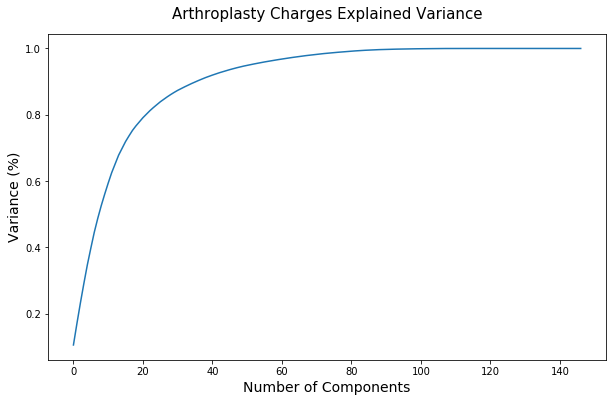

In [66]:
pca = PCA().fit(XRescaled)
plt.figure(figsize=(10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Variance (%)', fontsize=14) #for each component
plt.title('Arthroplasty Charges Explained Variance', fontsize=15, pad=15)
plt.show()

Only need 80 components to explain 100% of variance, so we perform PCA with n_components=80.

In [33]:
pca = PCA(n_components=80)
XTransformed = pca.fit_transform(XRescaled)

Perform OLS Regression again with reduced dimensionality of features

In [34]:
XT_train, XT_test, y_train, y_test = train_test_split(XTransformed, y, test_size=0.33, random_state=13)

clfPCA = LinearRegression()
clfPCA.fit(XT_train, y_train)
y_pred_PCA = clfPCA.predict(XT_test)
print(clfPCA.score(XT_train, y_train))
print(clfPCA.score(XT_test, y_test))

0.6776931351006361
0.6847333918846594


OLS performance didn't improve! Boo! And no interpretability :(

## Random Forest Regressor

In [35]:
arthroDataRF = arthroData.drop(columns=['scale_fte_employees_on_payroll', 'scale_number_of_beds',
                                      'scale_totalPopulation', 'scale_totalInsured',
                                      'scale_countPerDrgPerFacIdPerYr', 'scale_countPerFacIdPerYr',
                                      'scale_ratioDrgToFacility', 'scale_numberOfPaymentTypes',
                                      'scale_numberUrgentAdmits', 'scale_ratioInsuredTotalPopulation',
                                      'scale_days', 'scale_avgNumberDays', 'scale_Total Charges'])
arthroDataRF.shape

(82116, 148)

In [36]:
X = arthroDataRF.drop(columns=['Total Charges'])
y = arthroDataRF['Total Charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

### Hyperparameter Tuning: max_depth

In [37]:
max_depth = [5, 10, 15, 20, 25, 30, 35, 40]
depthTestScores = []
depthTrainScores = []
depthOOBScores = []

for n in max_depth:
    rf = RandomForestRegressor(n_estimators=100, max_depth=n, random_state=13, oob_score=True)
    rf.fit(X_train, y_train)
    depthTrainScores.append(rf.score(X_train, y_train))
    depthTestScores.append(rf.score(X_test, y_test))
    depthOOBScores.append(rf.oob_score_)

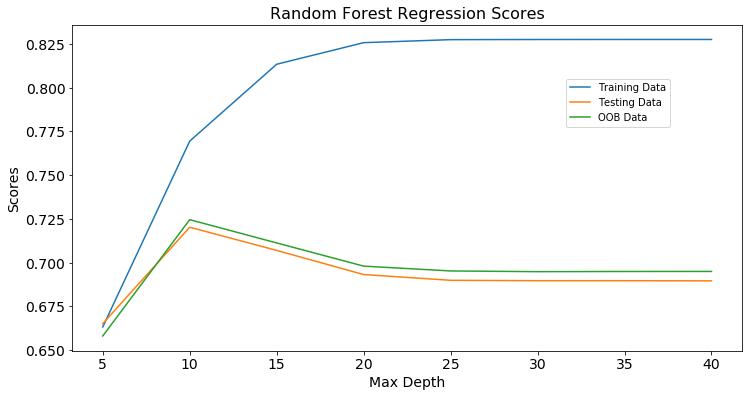

In [38]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(max_depth, depthTrainScores, label='Training Data')
plt.plot(max_depth, depthTestScores, label='Testing Data')
plt.plot(max_depth, depthOOBScores, label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('Max Depth', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9, 0.85))
plt.show()

Choose max_depth=12 as parameter.

### Hyperparameter Tuning: n_estimators

In [39]:
n_estimators = [1, 10, 20, 50, 70, 100, 120, 150]
nTestScores = []
nTrainScores = []
nOOBScores = []

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=13, max_depth=12, oob_score=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    nTrainScores.append(rf.score(X_train, y_train))
    nTestScores.append(rf.score(X_test, y_test))
    nOOBScores.append(rf.oob_score_)

C:\Users\rachelsim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\rachelsim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\rachelsim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


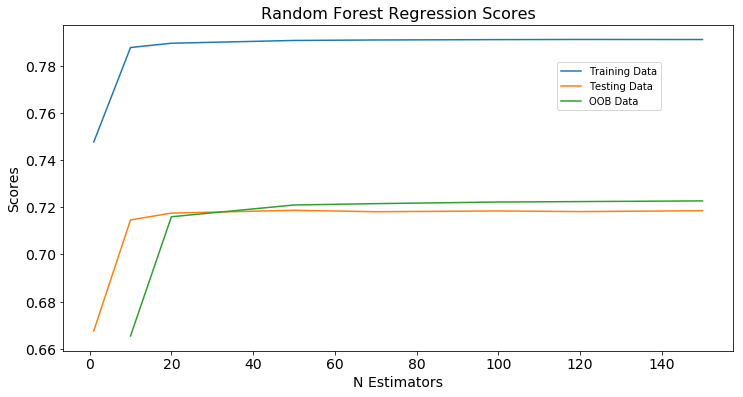

In [40]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(n_estimators, nTrainScores, label='Training Data')
plt.plot(n_estimators, nTestScores, label='Testing Data')
plt.plot(n_estimators[1:], nOOBScores[1:], label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('N Estimators', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9,0.9))
plt.show()

Choose n_estimators = 40.

### RFR Model 1: n_estimators=40 and max_depth=12

In [45]:
rf = RandomForestRegressor(n_estimators=40, random_state=13, max_depth=12, oob_score=True)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(rf.score(X_train, y_train))
print(rf.oob_score_)
print(rf.score(X_test, y_test))

0.7906171847399243
0.7205604262714136
0.7184953443591287


#### RFR Model 1: Feature Importance

In [46]:
importances = list(rf.feature_importances_)
rfFeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rfFeatImpt = sorted(rfFeatImpt, key = lambda x: x[1], reverse = True)
for pair in rfFeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: hsa_Long Island                                                   Importance: 0.27
Variable: hsa_Hudson Valley                                                 Importance: 0.17
Variable: hsa_New York City                                                 Importance: 0.14
Variable: number_of_beds                                                    Importance: 0.05
Variable: days                                                              Importance: 0.05
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: Hospital Ownership_Voluntary non-profit - Church                  Importance: 0.03
Variable: avgNumberDays                                                     Importance: 0.03
Variable: APR Severity of Illness Code                                      Importance: 0.02
Variable: yr                                                                Importance: 0.02
Variable: Hospital overall rating                                     

### RFR Model 2: n_estimators=40, max_depth=12 and bootstrap=True

In [47]:
rf2 = RandomForestRegressor(n_estimators=40, random_state=13, max_depth=12, oob_score=True, bootstrap=True)
rf2.fit(X_train, y_train)
y_pred = rf2.predict(X_test)

print(rf2.score(X_train, y_train))
print(rf2.oob_score_)
print(rf2.score(X_test, y_test))

0.7906171847399243
0.7205604262714136
0.7184953443591287


#### RFR Model 2: Feature Importance

In [49]:
importances = list(rf2.feature_importances_)
rf2FeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rf2FeatImpt = sorted(rf2FeatImpt, key = lambda x: x[1], reverse = True)
for pair in rf2FeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: hsa_Long Island                                                   Importance: 0.27
Variable: hsa_Hudson Valley                                                 Importance: 0.17
Variable: hsa_New York City                                                 Importance: 0.14
Variable: number_of_beds                                                    Importance: 0.05
Variable: days                                                              Importance: 0.05
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: Hospital Ownership_Voluntary non-profit - Church                  Importance: 0.03
Variable: avgNumberDays                                                     Importance: 0.03
Variable: APR Severity of Illness Code                                      Importance: 0.02
Variable: yr                                                                Importance: 0.02
Variable: Hospital overall rating                                     

### RF Model 3: remove features with 0 importance

In [50]:
unimptFeat = []

for pair in rf2FeatImpt:
    if pair[1] == 0:
        unimptFeat.append(pair[0])
        
unimptFeat.append('Total Charges')

In [51]:
X = arthroDataRF.drop(columns=unimptFeat)
y = arthroDataRF['Total Charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=13)

In [52]:
rf3 = RandomForestRegressor(n_estimators=40, random_state=13, max_depth=12, oob_score=True, bootstrap=True)
rf3.fit(X_train, y_train)
y_pred = rf3.predict(X_test)

print(rf3.score(X_train, y_train))
print(rf3.oob_score_)
print(rf3.score(X_test, y_test))

0.786838213280497
0.7199113374556992
0.7150889748856798


In [53]:
importances = list(rf3.feature_importances_)
rf3FeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rf3FeatImpt = sorted(rf3FeatImpt, key = lambda x: x[1], reverse = True)
for pair in rf3FeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: hsa_Long Island                                                   Importance: 0.27
Variable: hsa_Hudson Valley                                                 Importance: 0.17
Variable: hsa_New York City                                                 Importance: 0.14
Variable: number_of_beds                                                    Importance: 0.05
Variable: days                                                              Importance: 0.05
Variable: avgNumberDays                                                     Importance: 0.04
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: Hospital Ownership_Voluntary non-profit - Church                  Importance: 0.03
Variable: APR Severity of Illness Code                                      Importance: 0.02
Variable: yr                                                                Importance: 0.02
Variable: Hospital overall rating                                     

### RF Model 4: Optimize max_depth and n_estimators

In [55]:
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
depthTestScoresNew = []
depthTrainScoresNew = []
depthOOBScoresNew = []

for n in max_depth:
    rf = RandomForestRegressor(n_estimators=40, max_depth=n, random_state=13, oob_score=True)
    rf.fit(X_train, y_train)
    depthTrainScoresNew.append(rf.score(X_train, y_train))
    depthTestScoresNew.append(rf.score(X_test, y_test))
    depthOOBScoresNew.append(rf.oob_score_)

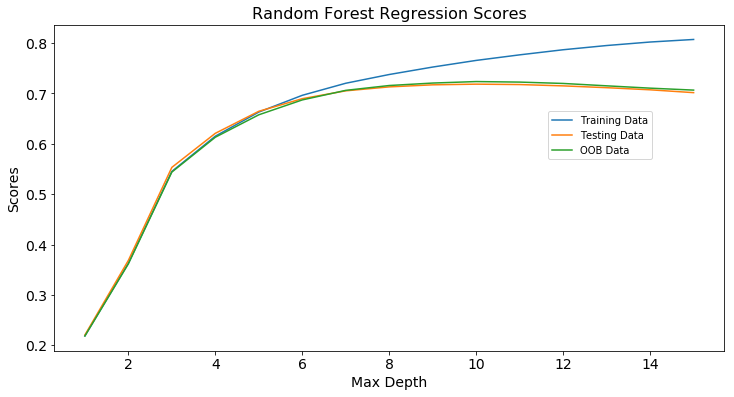

In [61]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(max_depth, depthTrainScoresNew, label='Training Data')
plt.plot(max_depth, depthTestScoresNew, label='Testing Data')
plt.plot(max_depth, depthOOBScoresNew, label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('Max Depth', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9, 0.75))
plt.show()

In [57]:
n_estimators = [1, 10, 20, 50, 70, 100]
nTestScoresNew = []
nTrainScoresNew = []
nOOBScoresNew = []

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=13, max_depth=9, oob_score=True)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    nTrainScoresNew.append(rf.score(X_train, y_train))
    nTestScoresNew.append(rf.score(X_test, y_test))
    nOOBScoresNew.append(rf.oob_score_)

C:\Users\rachelsim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\rachelsim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\rachelsim\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:724: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


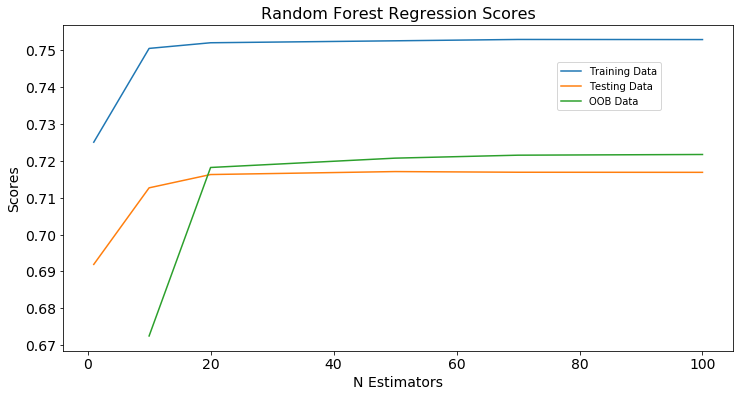

In [62]:
plt.figure(figsize=(12,6))
plt.title('Random Forest Regression Scores', fontsize=16)
plt.plot(n_estimators, nTrainScoresNew, label='Training Data')
plt.plot(n_estimators, nTestScoresNew, label='Testing Data')
plt.plot(n_estimators[1:], nOOBScoresNew[1:], label='OOB Data')
plt.xticks(fontsize=14)
plt.xlabel('N Estimators', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Scores', fontsize=14)
plt.legend(bbox_to_anchor=(0.9,0.9))
plt.show()

In [63]:
rf4 = RandomForestRegressor(n_estimators=30, random_state=13, max_depth=9, oob_score=True, bootstrap=True)
rf4.fit(X_train, y_train)
y_pred = rf4.predict(X_test)

print(rf4.score(X_train, y_train))
print(rf4.oob_score_)
print(rf4.score(X_test, y_test))

0.752356836682286
0.719698073327272
0.7168190440941511


In [67]:
importances = list(rf4.feature_importances_)
rf4FeatImpt = [(feature, round(importance, 2)) for feature, importance in zip(list(X.columns), importances)]
rf4FeatImpt = sorted(rf4FeatImpt, key = lambda x: x[1], reverse = True)
for pair in rf4FeatImpt:
    print('Variable: {:65} Importance: {}'.format(*pair))

Variable: hsa_Long Island                                                   Importance: 0.29
Variable: hsa_Hudson Valley                                                 Importance: 0.18
Variable: hsa_New York City                                                 Importance: 0.14
Variable: number_of_beds                                                    Importance: 0.05
Variable: days                                                              Importance: 0.05
Variable: ratioDrgToFacility                                                Importance: 0.03
Variable: Hospital Ownership_Voluntary non-profit - Church                  Importance: 0.03
Variable: avgNumberDays                                                     Importance: 0.03
Variable: yr                                                                Importance: 0.02
Variable: Hospital overall rating                                           Importance: 0.02
Variable: fte_employees_on_payroll                                    